In [2]:
## SRC toy model with TCS ## 
import numpy as np 
import numpy.linalg as LA
import matplotlib.pyplot as plt
import sys
sys.path.append('../cust_python')
import optimoe.tr_mat as opt
from optimoe.tr_mat import *
import scipy.io as sio
import scipy.signal as sig


In [3]:
PRC_data = sio.loadmat('/Users/daniel_vander-hyde/Documents/MATLAB/PRC_rtgp_with_lensing/inputBeamParams.mat')

In [161]:
## Parameters grabbed from LHO.py

#Lens vars 
pow_CO2 = 0 #CO2 power
pow_SR3_RH = 5
pow_RH = .8
o_n = 1 #order number

#calibration coefficients
alpha_CO2 = 2.50e-5         # TCS SIM (single pass lens)
alpha_RH_ITM = 9e-6         # TCS SIM (single pass lens)
alpha_RH_SR3 = 29e-6/(10.0) # DCC T1600096
# or 
beta_RH_SR3 = .0375/(10.0)


fITM = PRC_data['fITM']
fCP =1.0/(15e-6)

if pow_CO2 == 0:
    opt_pow_CP = 0
else: 
    opt_pow_CP = pow_CO2*alpha_CO2
    

lens_ITM = opt.lens(fITM)
lens_ITM_cold = opt.lens(PRC_data['fITM'])
lens_CP = opt.lens(fCP)
lens_CP_hot = opt.lens(1/(1/fCP+opt_pow_CP))

## SRC parameters ## (all lengths are in m)
SRM_ROC = -5.678 #-5.638 in TCS SIM
L_SRM_SR2 = 15.739 #
SR2_ROC = -6.424
L_SR2_SR3 = 15.461
SR3_ROC = 36.013
L_SR3_BShr = 19.4657
L_BS_CP = 4.9296 #goes to BS HR surface
OPL_CP = .14512246
L_CP_ITMX = .0200
#L_SR3_ITM = 24.12
#L_CP_ITMX = 0
fITM = -4231.0 
ITM_ROC = 1940.03 

L_tot = L_SRM_SR2 + L_SR2_SR3 + L_SR3_BShr + L_BS_CP + OPL_CP + L_CP_ITMX

#Length vars
L_Mto2 = opt.space(L_SRM_SR2)
L_2to3 = opt.space(L_SR2_SR3)
L_BS_CP = opt.space(L_BS_CP)
L_OPL_CP = opt.space(OPL_CP)
L_CP_ITMX = opt.space(L_CP_ITMX)
L_3toBS = opt.space(L_SR3_BShr)

#Mirror vars 
cmirror_SR2 = opt.cmirror(SR2_ROC)
cmirror_SR3 = opt.cmirror(SR3_ROC)
cmirror_SR3_hot = opt.cmirror(SR3_ROC - beta_RH_SR3*pow_SR3_RH)
cmirror_SRM = opt.cmirror(SRM_ROC)
cmirror_ITM = opt.cmirror(-ITM_ROC)


In [3]:
## Parameters grabbed from Aidan


In [164]:
#Compute round trip matrices for the cold and hot 
SRC_RT_cold = cmirror_SRM*L_Mto2*cmirror_SR2*L_2to3*cmirror_SR3*L_3toBS*L_BS_CP*lens_CP*L_CP_ITMX*lens_ITM_cold*cmirror_ITM*lens_ITM_cold*L_CP_ITMX*lens_CP*L_BS_CP*L_3toBS*cmirror_SR3*L_2to3*cmirror_SR2*L_Mto2
SRC_RT_hot  = cmirror_SRM*L_Mto2*cmirror_SR2*L_2to3*cmirror_SR3_hot*L_3toBS*L_BS_CP*lens_CP_hot*L_CP_ITMX*lens_ITM_cold*cmirror_ITM*lens_ITM_cold*L_CP_ITMX*lens_CP_hot*L_BS_CP*L_3toBS*cmirror_SR3*L_2to3*cmirror_SR2*L_Mto2

In [165]:
#Round trip matrices w/ different order
#SRC_RT_cold_2 = cmirror_SRM*L_Mto2*cmirror_SR2*L_2to3*cmirror_SR3*L_3toBS*L_BS_CP*L_OPL_CP*L_CP_ITMX*lens_ITM_cold*cmirror_ITM*lens_ITM_cold_2*L_CP_ITMX*L_OPL_CP*L_BS_CP*L_3toBS*cmirror_SR3*L_2to3*cmirror_SR2*L_Mto2

In [166]:
gp_cold = opt.rt_gouy(SRC_RT_cold.astype('float'))
gp_hot = opt.rt_gouy(SRC_RT_hot.astype('float'))
print(gp_cold/np.pi*180)
print(gp_hot/np.pi*180)
gp_hot/np.pi*180 - gp_cold/np.pi*180 

34.90640920121831
41.99358568635876


7.0871764851404535

In [27]:
FSR = 299792458/(2*L_tot)
freq = np.arange(FSR, 2.5*FSR, 1.5*FSR/100000)
ind = range(len(freq))
fines = 114.0
nu_tms_cold = FSR*(gp_cold/(2*np.pi))
nu_tms_hot = FSR*(gp_hot/(2*np.pi))

In [28]:
# Power resonating in the cavity
def P_circ(nu, fines, fsr, P_max=1): 
    P = P_max/((1 +pow((2.0*fines/np.pi),2)*pow(np.sin((np.pi*nu)/fsr),2)))
    return P

In [29]:
P = [P_circ(i, fines, FSR) for i in freq] 
P_HOM_cold = [P_circ(i, fines, FSR + o_n*nu_tms_cold) for i in freq]
P_HOM_hot = [P_circ(i, fines, FSR + o_n*nu_tms_hot) for i in freq]

In [30]:
max_ind_cold = sig.find_peaks(P_HOM_cold)[0][0]
max_ind_hot = sig.find_peaks(P_HOM_hot)[0][0]

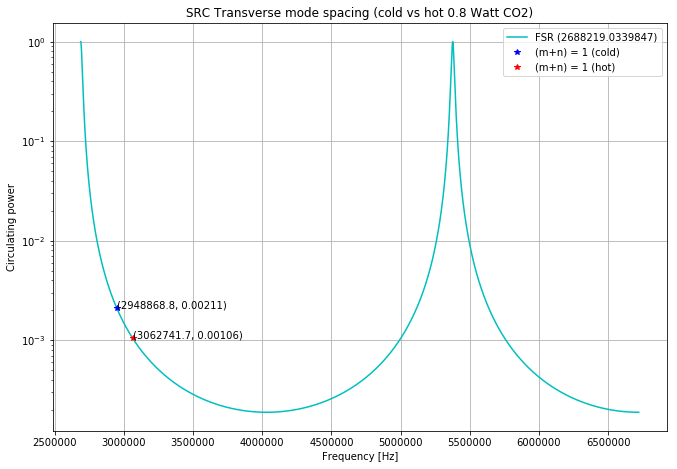

In [19]:
f = plt.figure(figsize=(11,7.5))
plt.semilogy(freq,P,'c')
#plt.semilogy(freq,P_HOM_cold,'r')
plt.semilogy(freq[max_ind_cold],P[max_ind_cold],'b*')
plt.semilogy(freq[max_ind_hot], P[max_ind_hot], 'r*')
plt.annotate('({}, {})'.format(round(freq[max_ind_cold],1),round(P[max_ind_cold],5)), xy=(freq[max_ind_cold],P[max_ind_cold]))
plt.annotate('({}, {})'.format(round(freq[max_ind_hot],1),round(P[max_ind_hot],5)), xy=(freq[max_ind_hot],P[max_ind_hot]))
plt.title('SRC Transverse mode spacing (cold vs hot {} Watt CO2)'.format(pow_CO2))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Circulating power')

plt.legend(('FSR ({})'.format(FSR), '(m+n) = {} (cold)'.format(o_n), '(m+n) = {} (hot)'.format(o_n)), loc='best')

plt.grid()
plt.show()

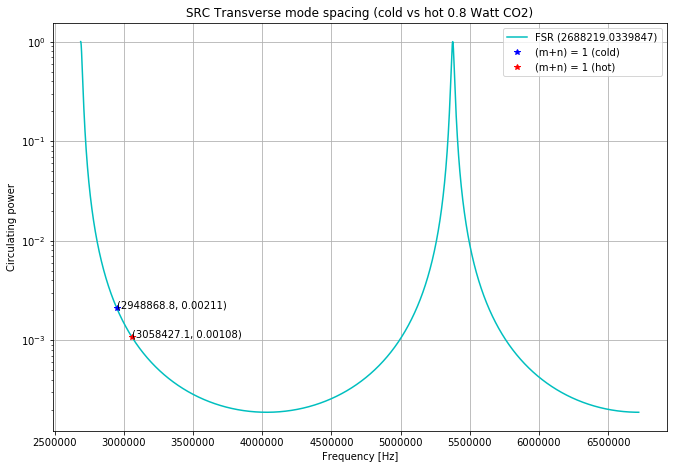

In [31]:
f = plt.figure(figsize=(11,7.5))
plt.semilogy(freq,P,'c')
#plt.semilogy(freq,P_HOM_cold,'r')
plt.semilogy(freq[max_ind_cold],P[max_ind_cold],'b*')
plt.semilogy(freq[max_ind_hot], P[max_ind_hot], 'r*')
plt.annotate('({}, {})'.format(round(freq[max_ind_cold],1),round(P[max_ind_cold],5)), xy=(freq[max_ind_cold],P[max_ind_cold]))
plt.annotate('({}, {})'.format(round(freq[max_ind_hot],1),round(P[max_ind_hot],5)), xy=(freq[max_ind_hot],P[max_ind_hot]))
plt.title('SRC Transverse mode spacing (cold vs hot {} Watt CO2)'.format(pow_CO2))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Circulating power')

plt.legend(('FSR ({})'.format(FSR), '(m+n) = {} (cold)'.format(o_n), '(m+n) = {} (hot)'.format(o_n)), loc='best')

plt.grid()
plt.show()

In [222]:
f.savefig('cav_tms_out.pdf',bbox_inches='tight')

In [53]:
PRC_data['fITM']

array([[-4312.43466851]])